# Example Complete Workflow: Coal Creek, CO

This workflow provides a complete working example to develop an unstructured mesh for an integrated hydrologic model at the Coal Creek catchment in the Taylor River Basin in Colorado.

It uses the following datasets:

* `NHD Plus` for the watershed boundary and hydrography.
* `NED` for elevation
* `NLCD` for land cover/transpiration/rooting depths
* `GLYHMPS` geology data for structural formations
* `SoilGrids 2017` for depth to bedrock and soil texture information
* `SSURGO` for soil data, where available, in the top 2m.

This is known as the "default" workflow because it is expected to work on any catchment in the conterminous US.  Other, more complicated soil structure workflows can be applied, but they are a bit less robust and often require gapfilling or making educated decisions about parameters.  This should need little to no user changes.

In [1]:
import os,sys
import numpy as np
import shapely
import logging
import scipy.ndimage
from matplotlib import pyplot as plt
import pandas
pandas.options.display.max_columns = None

import workflow
import workflow.source_list
import workflow.ui
import workflow.colors
import workflow.condition
import workflow.mesh
import workflow.split_hucs
import workflow.soil_properties

workflow.ui.setup_logging(1,None)

In [2]:
import ats_input_spec
import ats_input_spec.public
import ats_input_spec.io

Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid reprojecting meteorological forcing datasets.

In [3]:
huc = '140200010204' # Coal Creek, East & Taylor, Upper Co.
crs = workflow.crs.daymet_crs()

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [4]:
logging.info("")
logging.info(f"Meshing shape: {huc}")
logging.info("="*30)


2021-06-17 11:20:19,598 - root - INFO: 
2021-06-17 11:20:19,599 - root - INFO: Meshing shape: 140200010204
2021-06-17 11:20:19,600 - root - INFO: ==============================


A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [5]:
# set up a dictionary of source objects
sources = workflow.source_list.get_default_sources()
sources['hydrography'] = workflow.source_list.hydrography_sources['NHD Plus']
sources['HUC'] = workflow.source_list.huc_sources['NHD Plus']
workflow.source_list.log_sources(sources)

2021-06-17 11:20:19,605 - root - INFO: Using sources:
2021-06-17 11:20:19,606 - root - INFO: --------------
2021-06-17 11:20:19,607 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2021-06-17 11:20:19,607 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2021-06-17 11:20:19,608 - root - INFO: DEM: National Elevation Dataset (NED)
2021-06-17 11:20:19,608 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2021-06-17 11:20:19,609 - root - INFO: geologic structure: GLHYMPS version 2.0
2021-06-17 11:20:19,609 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2021-06-17 11:20:19,610 - root - INFO: soil thickness: None
2021-06-17 11:20:19,611 - root - INFO: meteorology: DayMet 1km


In [6]:
# load the huc
_, watershed = workflow.get_split_form_hucs(sources['HUC'], huc, len(huc), crs)

2021-06-17 11:20:19,615 - root - INFO: 
2021-06-17 11:20:19,615 - root - INFO: Loading level 12 HUCs in 140200010204
2021-06-17 11:20:19,616 - root - INFO: ------------------------------
2021-06-17 11:20:19,618 - root - INFO: Using HUC file "/Users/uec/code/watershed_workflow/data-library/hydrography/NHDPlus_H_1402_GDB/NHDPlus_H_1402.gdb"
2021-06-17 11:20:19,712 - root - INFO: ... found 1 HUCs
2021-06-17 11:20:19,713 - root - INFO:   -- 140200010204
2021-06-17 11:20:19,726 - root - INFO: Converting to out_crs
2021-06-17 11:20:19,761 - root - INFO: Converting to shapely
2021-06-17 11:20:19,763 - root - INFO: Creating split form


## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

### Get river network

This will download the river network from the NHD Plus database, and simplify the network, constructing a tree-like data structure.

In [7]:
simplify = 50 # length scale to target average edge

rivers = True
if rivers:
    # download/collect the river network within that shape's bounds
    _, reaches = workflow.get_reaches(sources['hydrography'], huc, 
                                      watershed.exterior().bounds, crs, crs)
    # simplify and prune rivers not IN the shape, constructing a tree-like data structure
    # for the river network
    rivers = workflow.simplify_and_prune(watershed, reaches, filter=True, simplify=simplify, 
                                         snap=False, cut_intersections=False,
                                         ignore_small_rivers=2,  prune_by_area_fraction=0.03)


else:
    rivers = list()
    workflow.split_hucs.simplify(watershed, simplify)
    


2021-06-17 11:20:19,772 - root - INFO: 
2021-06-17 11:20:19,773 - root - INFO: Loading Hydrography
2021-06-17 11:20:19,773 - root - INFO: ------------------------------
2021-06-17 11:20:19,774 - root - INFO: Loading streams in HUC 140200010204
2021-06-17 11:20:19,775 - root - INFO:          and/or bounds (-589129.2083284792, -364373.6464318802, -578347.216132635, -357432.470730077)
2021-06-17 11:20:19,776 - root - INFO:   Using Hydrography file "/Users/uec/code/watershed_workflow/data-library/hydrography/NHDPlus_H_1402_GDB/NHDPlus_H_1402.gdb"
2021-06-17 11:20:19,777 - root - INFO:   National Hydrography Dataset Plus High Resolution (NHDPlus HR): opening '/Users/uec/code/watershed_workflow/data-library/hydrography/NHDPlus_H_1402_GDB/NHDPlus_H_1402.gdb' layer 'NHDFlowline' for streams in '(-589129.2083284792, -364373.6464318802, -578347.216132635, -357432.470730077)'
/Users/uec/code/watershed_workflow/repos/master/workflow/sources/manager_nhd.py:171: RuntimeWarning: Sequential read of it

2021-06-17 11:20:34,296 - root - INFO: ... removing: 515195.5917952791 of 48577910.30431932
2021-06-17 11:20:34,297 - root - INFO: ... removing: 580186.9907251546 of 48577910.30431932
2021-06-17 11:20:34,297 - root - INFO: ... removing: 99501.35824469179 of 48577910.30431932
2021-06-17 11:20:34,297 - root - INFO: ... removing: 575651.0620277285 of 48577910.30431932
2021-06-17 11:20:34,298 - root - INFO: ... removing: 85976.87547314279 of 48577910.30431932
2021-06-17 11:20:34,298 - root - INFO: ... removing: 261131.99251191344 of 48577910.30431932
2021-06-17 11:20:34,298 - root - INFO: ... removing: 415696.77487098105 of 48577910.30431932
2021-06-17 11:20:34,299 - root - INFO: ... removing: 960003.0606779414 of 48577910.30431932
2021-06-17 11:20:34,299 - root - INFO: ... removing: 673356.6391414922 of 48577910.30431932
2021-06-17 11:20:34,300 - root - INFO: ... removing: 11707.259395429417 of 48577910.30431932
2021-06-17 11:20:34,300 - root - INFO: ... removing: 517046.23758733936 of 48

/Users/Shared/ornldev/code/miniconda3/envs/watershed_workflow_20210603/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


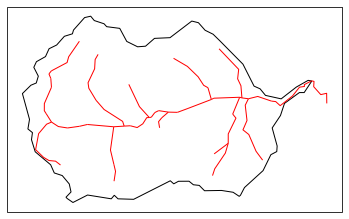

In [8]:
# plot what we have so far -- an image of the HUC and its stream network
fig, ax = workflow.plot.get_ax(crs)

workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)


### Generate meshes using river network and watershed shape

Triangulation refinement: refine triangles if their area (in m^2) is greater than A(d), where d is the 
distance from the triangle centroid to the nearest stream.  A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and linearly interpolates between the two endpoints.

2021-06-17 11:20:34,573 - root - INFO: 
2021-06-17 11:20:34,574 - root - INFO: Meshing
2021-06-17 11:20:34,575 - root - INFO: ------------------------------
2021-06-17 11:20:34,583 - root - INFO: Triangulating...
2021-06-17 11:20:34,584 - root - INFO:    75 points and 75 facets
2021-06-17 11:20:34,584 - root - INFO:  checking graph consistency
2021-06-17 11:20:34,584 - root - INFO:  tolerance is set to 1
2021-06-17 11:20:34,585 - root - INFO:  building graph data structures
2021-06-17 11:20:34,586 - root - INFO:  triangle.build...
2021-06-17 11:20:35,693 - root - INFO:   ...built: 2278 mesh points and 4380 triangles
2021-06-17 11:20:35,694 - root - INFO: Plotting triangulation diagnostics
2021-06-17 11:20:35,977 - root - INFO:   min area = 1888.8451080322266
2021-06-17 11:20:35,978 - root - INFO:   max area = 49990.58940124512


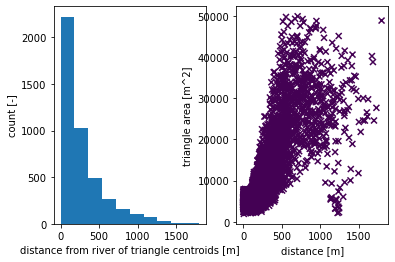

In [9]:
d0 = 100; d1 = 500
A0 = 8000; A1 = 50000 # [100, 310]m

# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
mesh_points2, mesh_tris, areas, distances = workflow.triangulate(watershed, rivers, 
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               diagnostics=True,
                                               )

### Map mesh to DEM

Download a DEM from USGS NED and elevate the triangle nodes to the DEM.

In [10]:
# download the needed rasters
dem_profile, dem = workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs)

2021-06-17 11:20:36,158 - root - INFO: 
2021-06-17 11:20:36,159 - root - INFO: Loading Raster
2021-06-17 11:20:36,159 - root - INFO: ------------------------------
2021-06-17 11:20:36,160 - root - INFO: Collecting raster
2021-06-17 11:20:36,184 - root - INFO: Collecting DEMs to tile bounds: [-107.11634327439819, 38.81770288243979, -106.96736783084837, 38.90466788650249]
2021-06-17 11:20:36,186 - root - INFO:   Need:
2021-06-17 11:20:36,187 - root - INFO:     /Users/uec/code/watershed_workflow/data-library/dem/USGS_NED_1as_n39_w108.tif
2021-06-17 11:20:36,187 - root - INFO:     /Users/uec/code/watershed_workflow/data-library/dem/USGS_NED_1as_n39_w107.tif
2021-06-17 11:20:36,188 - root - INFO: source files already exist!
2021-06-17 11:20:36,222 - root - INFO: ... got raster of shape: (314, 537)
2021-06-17 11:20:36,232 - root - INFO: ... got raster bounds: (-107.11634327439819, 38.90466788650249, -106.96717660772657, 38.81744566419919)


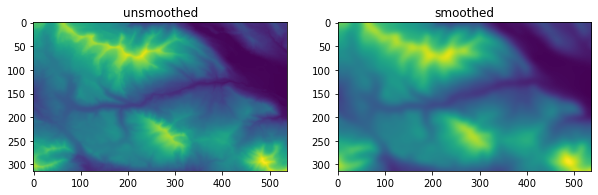

In [11]:
# noting that the DEM is a 30m raster, and we want to run at a coarser resolution of ~100-300m, 
# the DEM will look quite rough.  Smooth a small amount.  Note better algorithms could be used 
# here, but for now we just use Gaussian smoothing.
dem_sm = scipy.ndimage.gaussian_filter(dem, 5, mode='nearest')

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(dem)
axs[0].set_title('unsmoothed')
axs[1].imshow(dem_sm)
txt = axs[1].set_title('smoothed')

In [12]:
# elevate the x,y points onto the DEM to get a z coordinate
mesh_points3 = workflow.elevate(mesh_points2, crs, dem_sm, dem_profile)

2021-06-17 11:20:36,450 - root - INFO: 
2021-06-17 11:20:36,451 - root - INFO: Elevating Triangulation to DEM
2021-06-17 11:20:36,452 - root - INFO: ------------------------------


In [13]:
# construct the 2D mesh
m2 = workflow.mesh.Mesh2D(mesh_points3.copy(), list(mesh_tris))

In [14]:
# hydrologically condition the mesh, removing pits
workflow.condition.fill_pits(m2)


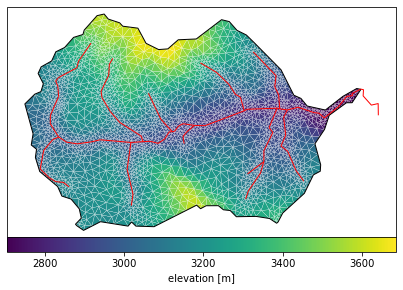

In [15]:
# plot the resulting surface mesh
fig, ax = workflow.plot.get_ax(crs, window=[0.05,0.1,0.9,0.8])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])

mp = workflow.plot.triangulation(m2.coords, m2.conn, crs, ax=ax, 
                                 color='elevation', edgecolor='white', linewidth=0.2)
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)
ax.set_aspect('equal', 'datalim')
txt = cbar.ax.set_xlabel('elevation [m]', loc='center')


## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed forest.

In [16]:
# download the NLCD raster
lc_profile, lc_raster = workflow.get_raster_on_shape(sources['land cover'], 
                                                     watershed.exterior(), crs)

# resample the raster to the triangles
lc = workflow.values_from_raster(m2.centroids(), crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))


2021-06-17 11:20:36,958 - root - INFO: 
2021-06-17 11:20:36,958 - root - INFO: Loading Raster
2021-06-17 11:20:36,959 - root - INFO: ------------------------------
2021-06-17 11:20:36,960 - root - INFO: Collecting raster
2021-06-17 11:20:36,966 - root - INFO: CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["meters",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
2021-06-17 11:20:37,034 - root - INFO: ... got raster of shape: (245, 374)
2021-06-17 11:20:37,044 - root - INFO: ... got raster bounds:

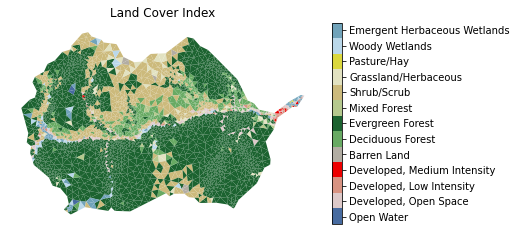

In [17]:
# plot the image
# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                workflow.colors.generate_nlcd_colormap(lc)

fig, ax = workflow.plot.get_ax(crs)
polys = workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, norm=nlcd_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)

workflow.colors.colorbar_index(ncolors=len(np.unique(lc)), cmap=nlcd_cmap, labels = nlcd_labels) 

ax.set_title("Land Cover Index")
ext = ax.axis('off')


In [18]:
# we don't really need all of these.  Keep Evergreen, Deciduous, Shrub, and merge the rest into "Other"
nlcd_color_new = 99 * np.ones_like(lc)

groupings = {
    42 : ['Evergreen Forest',],
    41 : ['Deciduous Forest', 'Mixed Forest', 'Woody Wetlands'],
    52 : ['Dwarf Scrub', 'Shrub/Scrub', 'Grassland/Herbaceous', 'Sedge/Herbaceous', 
                     'Pasture/Hay', 'Cultivated Crops'],
}

for k,v in groupings.items():
    for label in v:
        index = sources['land cover'].indices[label]
        nlcd_color_new[np.where(lc == index)] = k
    
print(nlcd_color_new)

[42 99 99 ... 52 52 52]


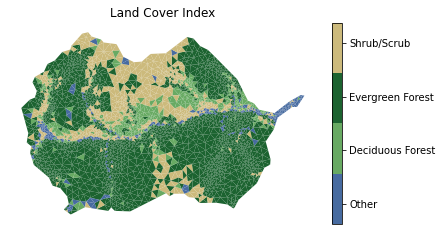

In [19]:
# plot the updated image, adding "other"
nlcd_color_new_other_as_water = np.where(nlcd_color_new == 99, 11, nlcd_color_new)

# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                workflow.colors.generate_nlcd_colormap(nlcd_color_new_other_as_water)

# make (water, 11) into (other, 99)
nlcd_labels[0] = 'Other'
nlcd_indices[0] = 99

fig, ax = workflow.plot.get_ax(crs)


polys = workflow.plot.mesh(m2, crs, ax=ax, color=nlcd_color_new_other_as_water, 
                           cmap=nlcd_cmap, norm=nlcd_norm, edgecolor='none', 
                        facecolor='color', linewidth=0.5)

workflow.colors.colorbar_index(ncolors=len(np.unique(nlcd_color_new_other_as_water)), 
                               cmap=nlcd_cmap, labels = nlcd_labels) 

ax.set_title("Land Cover Index")
ext = ax.axis('off')




## Subsurface properties

The default model uses GLHYMPS to identify geologic formations, and 

In [20]:
# download the NRCS soils data as shapes and project it onto the mesh

# -- download the shapes
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))
soil_profile, soil_survey, soil_survey_props = workflow.get_shapes(sources['soil structure'], 
                                                                   target_bounds, crs, crs, properties=True)

# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = np.array([shp.properties['mukey'] for shp in soil_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_raster, soil_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, 10, soil_survey,
                                              soil_ids, crs)

# -- resample the raster to the triangles
soil_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         soil_color_raster, soil_color_profile)

2021-06-17 11:20:39,430 - root - INFO: target bounds: (-589129.2083284792, -364373.6464318802, -578347.216132635, -357432.470730077)
2021-06-17 11:20:39,430 - root - INFO: 
2021-06-17 11:20:39,431 - root - INFO: Loading shapes
2021-06-17 11:20:39,431 - root - INFO: ------------------------------
2021-06-17 11:20:39,492 - root - INFO: Attempting to download source for target '/Users/uec/code/watershed_workflow/data-library/soil_structure/SSURGO/SSURGO_-107.1094_38.8261_-106.9727_38.9000.shp'
2021-06-17 11:20:39,504 - root - INFO:   Found 135 shapes.
2021-06-17 11:20:39,515 - root - INFO:   and crs: +init=epsg:4326 +type=crs
2021-06-17 11:20:39,528 - root - INFO: found 39 unique MUKEYs.
2021-06-17 11:20:41,331 - root - INFO: Running Rosetta for van Genutchen parameters
2021-06-17 11:20:41,332 - root - INFO:   database: /Users/uec/code/watershed_workflow/repos/master/workflow_tpls/rosetta/sqlite/rosetta.sqlite
2021-06-17 11:20:41,332 - root - INFO:   model type: 3
2021-06-17 11:20:41,555 

Select only the soils within the watershed

In [21]:
soil_survey_props.set_index('mukey', inplace=True, drop=False)
soil_survey_props = soil_survey_props.loc[np.unique(soil_color), :]

/Users/Shared/ornldev/code/miniconda3/envs/watershed_workflow_20210603/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


(-589668.3076, -577808.1164, -364720.70475000003, -357085.41225)

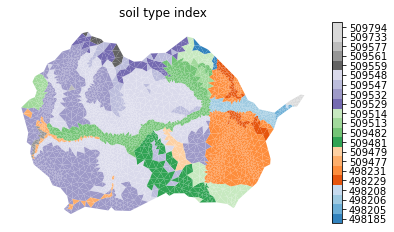

In [22]:
# plot the soil mukey
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(soil_color, cmap='tab20c')
fig, ax = workflow.plot.get_ax(crs)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color, 
                        cmap=cmap, norm = norm
                       )

workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color)), cmap=cmap, labels = labels) 

ax.set_title('soil type index')
ax.axis('off')
# fig.savefig('watershed_soils')

Median soil thickness [-] =  1.52


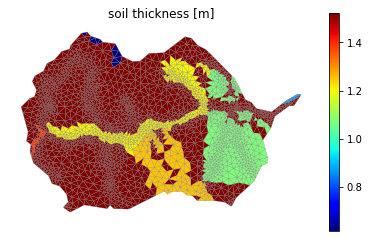

In [23]:
# what does soil thickness look like?
soil_thickness = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    soil_thickness[soil_color == mukey] = soil_survey_props.loc[mukey,'thickness [cm]']

soil_thickness = soil_thickness / 100
fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=soil_thickness, edgecolor='gray', cmap='jet')
ax.set_title('soil thickness [m]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04)
ax.axis('off')

print('Median soil thickness [-] = ', np.nanmedian(soil_thickness))

Median porosity [-] =  0.19334978070175438


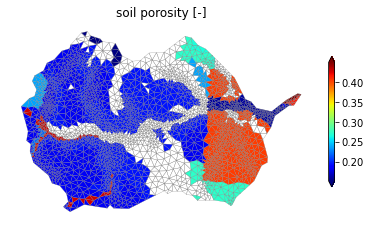

In [24]:
# plot of porosity from SSURGO
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'porosity [-]']

fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=iprop, edgecolor='gray', cmap='jet')
ax.set_title('soil porosity [-]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend = "both", shrink = 0.6)
ax.axis('off')

print('Median porosity [-] = ', np.nanmedian(iprop))

Min k [m^2] =  1.5907769355691275e-13


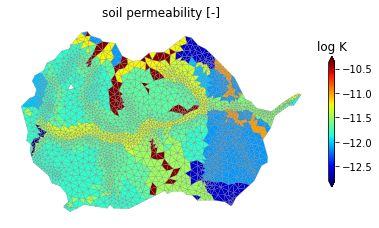

In [25]:
# plot of permeability
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'permeability [m^2]']

fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=np.log10(iprop), edgecolor='gray', cmap='jet')
ax.set_title('soil permeability [-]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend = "both", shrink = 0.6)
cb.ax.set_title('log K')
ax.axis('off')

print('Min k [m^2] = ', np.nanmin(iprop))

In [26]:
# Note the missing data (white).  This is because some SSURGO map units have no formation with complete 
# information.  So we merge the above available data, filling where possible and dropping regions that
# do not have a complete set of properties.
soil_survey_props_clean = soil_survey_props.copy()

# later scripts expect 'native_index' as a standard name of holding onto the original IDs
soil_survey_props_clean.rename_axis('native_index', inplace=True)
soil_survey_props_clean.rename(columns={'mukey':'native_index'}, inplace=True)

# need thickness in m
soil_survey_props_clean['thickness [cm]'] = soil_survey_props_clean['thickness [cm]']/100.
soil_survey_props_clean.rename(columns={'thickness [cm]':'thickness [m]'}, inplace=True)


def replace_column_nans(df, col_nan, col_replacement):
    """In a df, replace col_nan entries by col_replacement if is nan.  In Place!"""
    row_indexer = df[col_nan].isna()
    df.loc[row_indexer, col_nan] = df.loc[row_indexer, col_replacement]
    return

# where poro or perm is nan, put Rosetta poro
replace_column_nans(soil_survey_props_clean, 'porosity [-]', 'Rosetta porosity [-]')
replace_column_nans(soil_survey_props_clean, 'permeability [m^2]', 'Rosetta permeability [m^2]')

# drop unnecessary columns
for col in ['Rosetta porosity [-]', 'Rosetta permeability [m^2]', 'bulk density [g/cm^3]', 'total sand pct [%]',
            'total silt pct [%]', 'total clay pct [%]']:
    soil_survey_props_clean.pop(col)
    
# drop nans
soil_survey_props_clean.dropna(inplace=True)
soil_survey_props_clean.reset_index(drop=True, inplace=True)
soil_survey_props_clean



,residual saturation [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],native_index,thickness [m],permeability [m^2],porosity [-],source
0,0.240269,0.000092,1.319916,498185,1.520000,2.279759e-13,0.265563,NRCS
1,0.181598,0.000139,1.457559,498205,1.520000,2.734080e-12,0.159737,NRCS
2,0.181598,0.000139,1.457559,498206,1.520000,2.734080e-12,0.159737,NRCS
3,0.208316,0.000071,1.420938,498208,1.520000,1.184189e-12,0.185986,NRCS
4,0.213285,0.000059,1.416784,498231,1.070000,7.331979e-13,0.403218,NRCS
5,0.175133,0.000103,1.383180,509477,1.520000,3.039095e-12,0.428779,NRCS
6,0.230885,0.000079,1.374540,509479,1.250000,3.172415e-12,0.378365,NRCS
7,0.230885,0.000079,1.374540,509481,1.250000,3.172415e-12,0.378365,NRCS
8,0.207877,0.000092,1.397760,509482,1.205000,4.654687e-12,0.369886,NRCS
9,0.219597,0.000072,1.395746,509513,1.520000,9.122162e-13,0.237423,NRCS


/Users/Shared/ornldev/code/miniconda3/envs/watershed_workflow_20210603/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


(-589668.3076, -577808.1164, -364720.70475000003, -357085.41225)

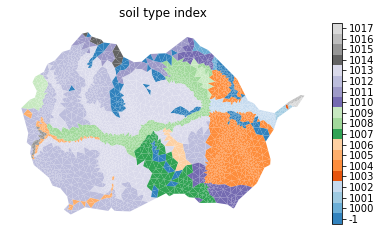

In [27]:
# create a new soil_color, keeping on those that are kept here and re-indexing to ATS indices
soil_color_new = -np.ones_like(soil_color)
for new_id, mukey in enumerate(soil_survey_props_clean['native_index']):
    soil_color_new[np.where(soil_color == mukey)] = 1000+new_id
    
# image the new soil_color
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(soil_color_new, cmap='tab20c')
fig, ax = workflow.plot.get_ax(crs)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color_new, 
                        cmap=cmap, norm=norm)

workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color_new)), cmap=cmap, labels=labels) 

ax.set_title('soil type index')
ax.axis('off')

### GLYHMPS geologic layer

GLYHMPS is complete in that it does not appear to have missing data, but does not have texture properties needed for Water Retention Models.  Instead we rely on scaling laws to fill the data.

In [28]:
# extract the GLYHMPS geologic structure data as shapes and project it onto the mesh
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))

_, geo_survey, geo_survey_props = workflow.get_shapes(sources['geologic structure'], 
                                                      target_bounds, crs, crs, properties=True)

# -- log the bounds targeted and found
logging.info('shape union bounds: {}'.format(
    shapely.ops.cascaded_union(geo_survey).bounds))

# -- determine the ID for each soil unit; this uniquely identifies formation
#    properties
geo_ids = np.array([shp.properties['id'] for shp in geo_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
geo_color_raster, geo_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, 10, geo_survey,
                                              geo_ids, crs)

# -- resample the raster to the triangles
geo_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         geo_color_raster, geo_color_profile)


2021-06-17 11:20:45,299 - root - INFO: target bounds: (-589129.2083284792, -364373.6464318802, -578347.216132635, -357432.470730077)
2021-06-17 11:20:45,299 - root - INFO: 
2021-06-17 11:20:45,300 - root - INFO: Loading shapes
2021-06-17 11:20:45,300 - root - INFO: ------------------------------
2021-06-17 11:20:45,301 - root - INFO: Getting shapes of GLHYMPS on bounds: (-589129.2083284792, -364373.6464318802, -578347.216132635, -357432.470730077)
2021-06-17 11:20:45,301 - root - INFO:   from file: /Users/uec/code/watershed_workflow/data-library/soil_structure/GLHYMPS/GLHYMPS.shp
2021-06-17 11:20:45,412 - fiona.ogrext - INFO: Failed to auto identify EPSG: 7
/Users/uec/code/watershed_workflow/repos/master/workflow/sources/manager_shape.py:76: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  shps = [s for (i,s) in fid.items(bbox=bounds)]
2021-06-17 11:20:52,162 - root - INFO: ... found 19 shapes
2021-06-17 11:2

In [29]:
# select the properties that appear in the mesh
geo_survey_props.set_index('id', inplace=True, drop=False)
geo_survey_props = geo_survey_props.loc[np.unique(geo_color), :]

(-589668.3076, -577808.1164, -364720.70475000003, -357085.41225)

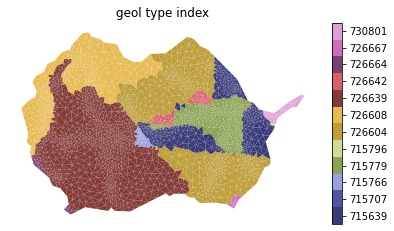

In [30]:
# plot the geologic formation id
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(geo_color, cmap='tab20b')

fig, ax = workflow.plot.get_ax(crs)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=geo_color, 
                        cmap=cmap, norm=norm)

workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color)), cmap=cmap, labels=labels) 

ax.set_title('geol type index')
ax.axis('off')

(-589668.3076, -577808.1164, -364720.70475000003, -357085.41225)

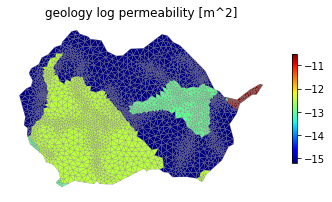

In [31]:
# plot permeability of the underlying geologic layer
iprop = np.empty(geo_color.shape, 'd')
for i in geo_survey_props.index:
    iprop[geo_color == i] = geo_survey_props.loc[i, 'permeability [m^2]']
    
fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=np.log10(iprop), edgecolor='gray', cmap='jet')
cbar = fig.colorbar(mp, shrink=0.5)
ax.set_title('geology log permeability [m^2]')
ax.axis('off')


(-589668.3076, -577808.1164, -364720.70475000003, -357085.41225)

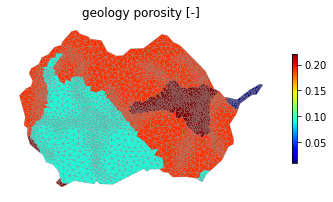

In [32]:
# plot porosity of the geologic layer
iprop = np.empty(geo_color.shape, 'd')
for i in geo_survey_props.index:
    iprop[geo_color == i] = geo_survey_props.loc[i, 'porosity [-]']

fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=iprop, edgecolor='gray', cmap='jet')
cbar = fig.colorbar(mp, shrink=0.5)
ax.set_title('geology porosity [-]')
ax.axis('off')


In [33]:
# note there are clearly some common regions -- no need to duplicate those with identical values.
geo_survey_props_clean = geo_survey_props.copy()
geo_survey_props_clean.pop('logk_stdev [-]')
geo_survey_props_clean.rename(columns={'id':'native_index'}, inplace=True)


def reindex_remove_duplicates(df, index=None):
    """Removes duplicates, creating a new index and saving the old index as tuples of duplicate values. In place!"""
    if index is not None:
        if index in df:
            df.set_index(index, drop=True, inplace=True)
    
    index_name = df.index.name

    # identify duplicate rows
    duplicates = list(df.groupby(list(df)).apply(lambda x: tuple(x.index)))

    # order is preserved
    df.drop_duplicates(inplace=True)
    df.reset_index(inplace=True)
    df[index_name] = duplicates
    return

reindex_remove_duplicates(geo_survey_props_clean, 'native_index')
geo_survey_props_clean

,native_index,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-]
0,"(715639, 715796, 726604, 726608)",GLHYMPS,6.309573e-16,0.19,0.000025,2.0,0.01
1,"(715707, 715779, 726642, 726664)",GLHYMPS,1.000000e-13,0.22,0.000294,2.0,0.01
2,"(715766, 726639, 726667)",GLHYMPS,3.162278e-13,0.09,0.000775,2.0,0.01
3,"(730801,)",GLHYMPS,3.019952e-11,0.01,0.007574,2.0,0.01


/Users/Shared/ornldev/code/miniconda3/envs/watershed_workflow_20210603/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


(-589668.3076, -577808.1164, -364720.70475000003, -357085.41225)

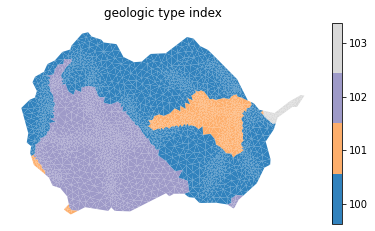

In [34]:
# create a new geologic layer color, keeping on those that are kept here and re-indexing to ATS indices
geo_color_new = -np.ones_like(geo_color)
for new_id, old_id_dups in enumerate(geo_survey_props_clean['native_index']):
    for old_id in old_id_dups:
        geo_color_new[np.where(geo_color == old_id)] = 100+new_id
    
# image the new geo_color
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(geo_color_new, cmap='tab20c')
fig, ax = workflow.plot.get_ax(crs)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=geo_color_new, 
                        cmap=cmap, norm=norm)

workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color_new)), cmap=cmap, labels=labels) 

ax.set_title('geologic type index')
ax.axis('off')

## Depth-to-bedrock

Depth to bedrock is taken from the [SoilGrids](http://globalchange.bnu.edu.cn/research/dtb.jsp) product.  Here we download a US-based, clipped version of this global product, as file sizes are quite large (all products potentially used total over 100GB).

In [35]:
DTB_source = workflow.source_list.structure_sources['SoilGrids2017']
DTB_profile, DTB_raster = workflow.get_raster_on_shape(DTB_source, watershed.exterior(), crs, 
                                                       nodata=-99999, variable='BDTICM')

# resample the raster to the triangles
DTB_raster = DTB_raster/100 #convert from cm to m
DTB = workflow.values_from_raster(m2.centroids(), crs, DTB_raster, DTB_profile)
DTB = np.where(DTB >= 0, DTB, np.nan)

2021-06-17 11:20:55,424 - root - INFO: 
2021-06-17 11:20:55,424 - root - INFO: Loading Raster
2021-06-17 11:20:55,425 - root - INFO: ------------------------------
2021-06-17 11:20:55,426 - root - INFO: Collecting raster
2021-06-17 11:20:55,431 - root - INFO: CRS: EPSG:4326
2021-06-17 11:20:55,431 - root - INFO: filename: /Users/uec/code/watershed_workflow/data-library/soil_structure/SoilGrids2017_US/BDTICM_M_250m_ll_us.tif
2021-06-17 11:20:55,491 - root - INFO: ... got raster of shape: (33, 63)
2021-06-17 11:20:55,502 - root - INFO: ... got raster bounds: (-107.10833619599228, 38.895835029995425, -106.97708621699222, 38.82708504099539)


bounds in my_crs: (-107.10634327439818, 38.82770288243979, -106.97736783084838, 38.89466788650249)


Text(0.5, 1.0, 'DTB [m]')

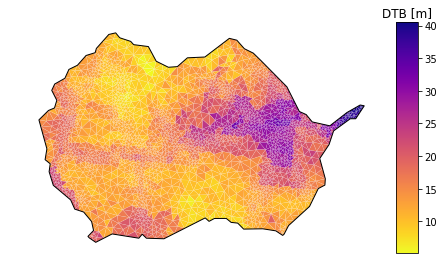

In [36]:
# plot the resulting surface mesh
fig, ax = workflow.plot.get_ax(crs, window=[0.05,0.1,0.9,0.8])
cbax = fig.add_axes([.95,0.1,0.05,0.8])

mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=DTB, cmap='plasma_r', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)

ax.set_aspect('equal', 'datalim')
ax.axis('off')

cbar.ax.set_title('DTB [m]')

## A combined, complete product?

As a default, we would like a material-driven (e.g. not fields for porosity, perm, etc, but soil classes, each with a common porosity/permeability/vG curve) default that is valid everywhere.  That makes it clear that we must rely on GLHYMPS as the only material-based product that is valid everywhere.  Other products may be layered on top of this, replacing GLHYMPS values, but the underlying layer should be based on GLHYMPS.  To fill in the van Genuchten properties, we relate alpha to permeability and choose a single common n and s_r.

Where available, we then choose to use SSURGO as a layer on top of GLHYMPS.  So start by using all GLHYMPS values, then override ones where SSURGO is valid with those values.  This will be the second model, and has then three layers -- a bedrock layer, a soil layer from 0 to 2m, and a geologic layer, using GLHYMPS values.  SoilGrids depth-to-bedrock will be used to provide the transition between bedrock and (where > 2m) the GLHYMPS "geologic" layer or (where < 2m) the SSURGO "soil" layer.  Where SSURGO has no values, the underlying GLHYMPS values will be used even in the top 2m.



## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

First, all integer IDs in Exodus files must be unique.  This includes Material IDs, side sets, etc.  We create the Material ID map and data frame.  This is used to standardize IDs from multiple data sources.  Traditionally, ATS numbers Material IDs/Side Sets as:

* 0-9 : reserved for boundaries, surface/bottom, etc
* 10-99 : Land Cover side sets, typically NLCD IDs are used
* 100-999 : geologic layer material IDs. 999 is reserved for bedrock.
* 1000-9999 : soil layer material IDs




In [37]:
# map SSURGO mukey to ATS_ID
soil_survey_props_clean['ats_id'] = range(1000, 1000+len(soil_survey_props_clean))
soil_survey_props_clean.set_index('ats_id', inplace=True)

# map GLHYMPS id to ATS_ID
geo_survey_props_clean['ats_id'] = range(100, 100+len(geo_survey_props_clean))
geo_survey_props_clean.set_index('ats_id', inplace=True)

bedrock_props = workflow.soil_properties.get_bedrock_properties()

# merge the properties databases
subsurface_props = pandas.concat([geo_survey_props_clean,
                                  soil_survey_props_clean,
                                  bedrock_props])

# save the properties to disk for use in generating input file
subsurface_props.to_csv('watershed_subsurface_properties.csv')
subsurface_props

,native_index,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],thickness [m]
ats_id,,,,,,,,
100,"(715639, 715796, 726604, 726608)",GLHYMPS,6.309573e-16,0.190000,0.000025,2.000000,0.010000,NaN
101,"(715707, 715779, 726642, 726664)",GLHYMPS,1.000000e-13,0.220000,0.000294,2.000000,0.010000,NaN
102,"(715766, 726639, 726667)",GLHYMPS,3.162278e-13,0.090000,0.000775,2.000000,0.010000,NaN
103,"(730801,)",GLHYMPS,3.019952e-11,0.010000,0.007574,2.000000,0.010000,NaN
1000,498185,NRCS,2.279759e-13,0.265563,0.000092,1.319916,0.240269,1.520000
1001,498205,NRCS,2.734080e-12,0.159737,0.000139,1.457559,0.181598,1.520000
1002,498206,NRCS,2.734080e-12,0.159737,0.000139,1.457559,0.181598,1.520000
1003,498208,NRCS,1.184189e-12,0.185986,0.000071,1.420938,0.208316,1.520000
1004,498231,NRCS,7.331979e-13,0.403218,0.000059,1.416784,0.213285,1.070000


Next we extrude the DEM to create a 3D mesh.

The most difficult aspect of extrusion is creating meshes that:
1. aren't huge numbers of cells
2. aren't huge cell thicknesses, especially near the surface
3. follow implied interfaces, e.g. bottom of soil and bottom of geologic layer

This is an iterative process that requires some care and some art.

In [38]:
# here we choose the bottom of the domain to be the maximum of the depth to bedrock.  
# This is really up to the user...
total_thickness = np.ceil(DTB.max())
print(f'total thickness: {total_thickness} m')

total_thickness = 41.0

total thickness: 41.0 m


In [39]:
# Generate a dz structure for the top 2m of soil
#
# here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
dzs, res = workflow.mesh.optimize_dzs(0.05, 0.5, 2, 10)
print(dzs)
print(sum(dzs))

[0.0500016  0.05030145 0.06625834 0.1110568  0.22600204 0.49640501
 0.49997989 0.49999487]
2.0


In [40]:
# this looks like it would work out, with rounder numbers:
dzs_soil = [0.05, 0.05, 0.05, 0.12, 0.23, 0.5, 0.5, 0.5]
print(sum(dzs_soil))

2.0


In [41]:
# 41m total thickness, minus 2m soil thickness, leaves us with 39 meters to make up.
# optimize again...
dzs2, res2 = workflow.mesh.optimize_dzs(1, 10, 39, 8)
print(dzs2)
print(sum(dzs2))

# how about...
dzs_geo = [1.0, 3.0,] + 7*[5.0,]
print(dzs_geo)
print(sum(dzs_geo))

[ 1.43810942  2.49456441  5.06733261  9.99999356  9.99999999 10.        ]
39.0
[1.0, 3.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
39.0


In [42]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- soil layer --
depth = 0
for dz in dzs_soil:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    br_or_geo = np.where(depth < DTB, geo_color_new, 999)
    soil_or_br_or_geo = np.where(np.bitwise_and(soil_color_new > 0, depth < soil_thickness),
                                 soil_color_new,
                                 br_or_geo)
    
    layer_mat_ids.append(soil_or_br_or_geo)
    depth += 0.5 * dz
    
# -- geologic layer --
for dz in dzs_geo:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(np.where(depth < DTB, geo_color_new, 999))
    depth += 0.5 * dz

# print the summary
workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2021-06-17 11:20:56,062 - root - INFO: Cell summary:
2021-06-17 11:20:56,063 - root - INFO: ------------------------------------------------------------
2021-06-17 11:20:56,064 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2021-06-17 11:20:56,064 - root - INFO: ------------------------------------------------------------
2021-06-17 11:20:56,065 - root - INFO:  00 	| 00 	| 1012 	|   0.050000 	|   0.000000
2021-06-17 11:20:56,066 - root - INFO:  01 	| 01 	| 1012 	|   0.050000 	|   0.050000
2021-06-17 11:20:56,066 - root - INFO:  02 	| 02 	| 1012 	|   0.050000 	|   0.100000
2021-06-17 11:20:56,067 - root - INFO:  03 	| 03 	| 1012 	|   0.120000 	|   0.150000
2021-06-17 11:20:56,068 - root - INFO:  04 	| 04 	| 1012 	|   0.230000 	|   0.270000
2021-06-17 11:20:56,068 - root - INFO:  05 	| 05 	| 1012 	|   0.500000 	|   0.500000
2021-06-17 11:20:56,069 - root - INFO:  06 	| 06 	| 1012 	|   0.500000 	|   1.000000
2021-06-17 11:20:56,069 - root - INFO:  07 	| 07 	|  102 	|   0.500000 	|   1.5

In [43]:
# extrude
m3 = workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [44]:
# add back on land cover side sets
surf_ss = m3.side_sets[1]

for index, name in zip(nlcd_indices, nlcd_labels):
    where = np.where(nlcd_color_new == index)[0]
    print(index, name, len(where))
    ss = workflow.mesh.SideSet(name, int(index), 
                            [surf_ss.elem_list[w] for w in where],
                            [surf_ss.side_list[w] for w in where])        
    m3.side_sets.append(ss)

99 Other 307
41 Deciduous Forest 530
42 Evergreen Forest 2680
52 Shrub/Scrub 863


In [45]:
# save to disk
try:
    os.remove('CoalCreek.exo')
except FileNotFoundError:
    pass
m3.write_exodus('CoalCreek.exo')


You are using exodus.py v 1.20.0 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: CoalCreek.exo
Closing exodus file: CoalCreek.exo


## Collect the DayMet raster covering this area



In [46]:
import workflow.daymet

In [47]:
start = "1-2010"
end = "365-2011"
bounds = watershed.exterior().bounds

dat, x, y = workflow.daymet.collectDaymet(bounds, crs, start, end)
ats = workflow.daymet.daymetToATS(dat)
attrs = workflow.daymet.getAttrs(bounds, start, end)
workflow.daymet.writeHDF5(ats, x, y, attrs, 'CoalCreek_DayMet_2010_2011.h5')

2021-06-17 11:20:58,288 - root - INFO: downloading variables: ['tmin', 'tmax', 'prcp', 'srad', 'vp', 'swe', 'dayl']
2021-06-17 11:20:58,322 - root - INFO: Collecting DayMet file to tile bounds: [-107.11930000000001, 38.8162, -106.9628, 38.9099]
2021-06-17 11:20:58,324 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_tmin_2010_38.9099x-107.1193_38.8162x-106.9628.nc
2021-06-17 11:20:58,366 - root - INFO: Collecting DayMet file to tile bounds: [-107.11930000000001, 38.8162, -106.9628, 38.9099]
2021-06-17 11:20:58,367 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_tmax_2010_38.9099x-107.1193_38.8162x-106.9628.nc
2021-06-17 11:20:58,409 - root - INFO: Collecting DayMet file to tile bounds: [-107.11930000000001, 38.8162, -106.9628, 38.9099]
2021-06-17 11:20:58,410 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_prcp_2

## Now write the ATS input file for all of this info...

In [48]:
# get an ATS "main" input spec list
main_list = ats_input_spec.public.get_main()

# this is somewhat up to the user -- where will the newly creaeted mesh, CoalCreek.exo, be 
# put relative to the simulation directory?
mesh_filename = '../data/CoalCreek.exo'

In [49]:
# add the subsurface and surface domains
#
# Note this also adds a "computational domain" region to the region list, and a vis spec 
# for "domain"
ats_input_spec.public.add_domain(main_list, 
                                 domain_name='domain', 
                                 dimension=3, 
                                 mesh_type='read mesh file', 
                                 mesh_args={'file':mesh_filename})
main_list['mesh']['domain']['build columns from set'] = 'surface'

# Note this also adds a "surface domain" region to the region list and a vis spec for 
# "surface"
ats_input_spec.public.add_domain(main_list,
                                domain_name='surface',
                                dimension=2,
                                mesh_type='surface',
                                mesh_args={'surface sideset name':'surface'})

# Add the snow and canopy domains, which are aliases to the surface
ats_input_spec.public.add_domain(main_list,
                                domain_name='snow',
                                dimension=2,
                                mesh_type='aliased',
                                mesh_args={'target':'surface'})
ats_input_spec.public.add_domain(main_list,
                                domain_name='canopy',
                                dimension=2,
                                mesh_type='aliased',
                                mesh_args={'target':'surface'})

# add the "surface boundary" list
ats_input_spec.public.add_region(main_list,
                                region_name='surface boundary',
                                region_type='boundary',
                                region_args={'entity': 'FACE'})

def add_labeled_set(name, label, entity_kind):
    """Helper function to add labeled sets to the main list"""
    ats_input_spec.public.add_region(main_list,
                                    region_name=name,
                                    region_type='labeled set',
                                    region_args={'label' : str(label), 
                                                 'file' : mesh_filename,
                                                 'format' : 'Exodus II',
                                                 'entity' : entity_kind})

# add the bottom and surface sets
add_labeled_set('bottom_face', 1, 'FACE')
add_labeled_set('surface', 2, 'FACE')

# add the NLCD labeled sets
for index, name in zip(nlcd_indices, nlcd_labels):
    add_labeled_set(name, index, 'FACE')

# add soil sets: note we need a way to name the set, so we use, e.g. SSURGO-MUKEY.
def soil_set_name(ats_id):
    if ats_id == 999:
        return 'bedrock'
    source = subsurface_props.loc[ats_id]['source']
    native_id = subsurface_props.loc[ats_id]['native_index']
    if type(native_id) in [tuple,list]:
        native_id = native_id[0]
    return f"{source}-{native_id}"

for ats_id in subsurface_props.index:
    set_name = soil_set_name(ats_id)
    add_labeled_set(set_name, ats_id, 'CELL')

print(main_list)

mesh [mesh-typed-spec-list] : [complete]
  domain [TypedCollection] : [complete]
    mesh type [string] : read mesh file
    read mesh file parameters [unknown derived parameter] : [complete]
      file [string] : ../data/CoalCreek.exo
    verify mesh [bool] : false
    deformable mesh [bool] : false
    build columns from set [string] : surface
    partitioner [string] : zoltan_rcb
  surface [TypedCollection] : [complete]
    mesh type [string] : surface
    surface parameters [unknown derived parameter] : [complete]
      surface sideset name [string] : surface
      verify mesh [bool] : false
      export mesh to file [string] : [optional]
    verify mesh [bool] : false
    deformable mesh [bool] : false
    build columns from set [string] : [optional]
    partitioner [string] : zoltan_rcb
  snow [TypedCollection] : [complete]
    mesh type [string] : aliased
    aliased parameters [unknown derived parameter] : [complete]
      target [string] : surface
    verify mesh [bool] : fals

In [50]:
# next write a land-cover section for each NLCD type
land_cover_list = ats_input_spec.public.known_specs['land-cover-spec-list']
main_list['state']['initial conditions']['land cover types'] = land_cover_list

def add_land_cover_default(main, name):
    """Adds a default land-cover type to the spec."""
    lc = main['state']['initial conditions']['land cover types'].append_empty(name)
    
    # set some basic defaults
    lc['Priestley-Taylor alpha of snow [-]'] = 1.26
    lc['Priestley-Taylor alpha of bare ground [-]'] = 1.26
    lc['Priestley-Taylor alpha of canopy [-]'] = 1.26
    lc['Priestley-Taylor alpha of transpiration [-]'] = 0.63

    lc['albedo of bare ground [-]'] = 0.4
    lc['emissivity of bare ground [-]'] = 0.98
    lc['albedo of canopy [-]'] = 0.11
    lc['emissivity of canopy [-]'] = 0.95
    
    lc["Beer's law extinction coefficient, shortwave [-]"] = 0.6
    lc["Beer's law extinction coefficient, longwave [-]"] = 5
    
    lc["snow transition depth [m]"] = 0.02
    lc["dessicated zone thickness [m]"] = 0.1
    lc["Clapp and Hornberger b [-]"] = 1
    
    # defaults for grass/no vei
    lc['rooting depth max [m]'] = 5.
    lc['rooting profile alpha [-]'] = 11.0
    lc['rooting profile beta [-]'] = 2.0
    
    
    # Note, the mafic potential values are likely pretty bad for the types of van Genuchten 
    # curves we are using (https://www.sciencedirect.com/science/article/pii/S0168192314000483).
    # Likely they need to be modified.  Note that these values are in [mm] from CLM TN 4.5 table 8.1, so the 
    # factor of 10 converts to [Pa].
    #
    # instead of using a factor of 10, we use a factor of 1 for closed and .1 for open to make this more 
    # physically viable for our VG models
    lc['mafic potential at fully closed stomata [Pa]'] = 275000.
    lc['mafic potential at fully open stomata [Pa]'] = 74000. * .1
    
    # by default we let the LAI take care of this rather than turn off deciduous 
    # transpiration manually the way that PRMS does it. 
    lc['leaf on time [doy]'] = -1
    lc['leaf off time [doy]'] = -1
    return lc

# add default lists for all types
for index, name in zip(nlcd_indices, nlcd_labels):
    lc = add_land_cover_default(main_list, name)

# update some defaults
# ['Other', 'Deciduous Forest', 'Evergreen Forest', 'Shrub/Scrub']
# note, these are from the CLM Technical Note v4.5
#
# Rooting depth curves from CLM TN 4.5 table 8.3
#
# Note, the mafic potential values are likely pretty bad for the types of van Genuchten 
# curves we are using (ETC -- add paper citation about this topic).  Likely they need
# to be modified.  Note that these values are in [mm] from CLM TN 4.5 table 8.1, so the 
# factor of 10 converts to [Pa]
#
# Note, albedo of canopy taken from CLM TN 4.5 table 3.1
land_cover_list['Evergreen Forest']['rooting profile alpha [-]'] = 7.0
land_cover_list['Evergreen Forest']['rooting profile beta [-]'] = 2.0
land_cover_list['Evergreen Forest']['rooting depth max [m]'] = 10.0
land_cover_list['Evergreen Forest']['mafic potential at fully closed stomata [Pa]'] = 255000
land_cover_list['Evergreen Forest']['mafic potential at fully open stomata [Pa]'] = 66000 * .1
land_cover_list['Evergreen Forest']['albedo of canopy [-]'] = 0.07

land_cover_list['Deciduous Forest']['rooting profile alpha [-]'] = 6.0
land_cover_list['Deciduous Forest']['rooting profile beta [-]'] = 2.0
land_cover_list['Deciduous Forest']['rooting depth max [m]'] = 10.0
land_cover_list['Deciduous Forest']['mafic potential at fully closed stomata [Pa]'] = 224000
land_cover_list['Deciduous Forest']['mafic potential at fully open stomata [Pa]'] = 35000 * .10
land_cover_list['Deciduous Forest']['albedo of canopy [-]'] = 0.1

print(land_cover_list)

Other [TypedCollection] : [complete]
  rooting depth max [m] [double] : 5.00000000
  rooting profile alpha [-] [double] : 11.00000000
  rooting profile beta [-] [double] : 2.00000000
  mafic potential at fully closed stomata [Pa] [double] : 275000.00000000
  mafic potential at fully open stomata [Pa] [double] : 7400.00000000
  leaf on time [doy] [double] : -1.00000000
  leaf off time [doy] [double] : -1.00000000
  Priestley-Taylor alpha of snow [-] [double] : 1.26000000
  Priestley-Taylor alpha of bare ground [-] [double] : 1.26000000
  Priestley-Taylor alpha of canopy [-] [double] : 1.26000000
  Priestley-Taylor alpha of transpiration [-] [double] : 0.63000000
  interception coefficient [-] [double] : nan
  albedo of bare ground [-] [double] : 0.40000000
  emissivity of bare ground [-] [double] : 0.98000000
  albedo of canopy [-] [double] : 0.11000000
  emissivity of canopy [-] [double] : 0.95000000
  Beer's law extinction coefficient, shortwave [-] [double] : 0.60000000
  Beer's law 

In [51]:
# finally, we write soil property specs for porosity, permeability, and WRMs
poro_eval = main_list['state']['field evaluators'].append_empty('base_porosity')
poro_eval.set_type('independent variable', ats_input_spec.public.known_specs['independent-variable-evaluator-spec'])
poro_eval['constant in time'] = True

perm_eval = main_list['state']['field evaluators'].append_empty('permeability')
perm_eval.set_type('independent variable', ats_input_spec.public.known_specs['independent-variable-evaluator-spec'])
perm_eval['constant in time'] = True

wrm_eval = main_list['state']['field evaluators'].append_empty('saturation_liquid')
wrm_eval.set_type('WRM rel perm', ats_input_spec.public.known_specs['rel-perm-evaluator-spec'])
wrm_eval['boundary rel perm strategy'] = 'surface rel perm'
wrm_eval['permeability rescaling'] = 1e7


print(main_list['state']['field evaluators'])

base_porosity [TypedCollection] : [incomplete]
  field evaluator type [string] : independent variable
  constant in time [bool] : true
  function [composite-vector-function-spec-list] : [incomplete]
    
permeability [TypedCollection] : [incomplete]
  field evaluator type [string] : independent variable
  constant in time [bool] : true
  function [composite-vector-function-spec-list] : [incomplete]
    
saturation_liquid [TypedCollection] : [incomplete]
  field evaluator type [string] : WRM rel perm
  use density on viscosity in rel perm [bool] : true
  boundary rel perm strategy [string] : surface rel perm
  minimum rel perm cutoff [double] : 0.00000000
  permeability rescaling [double] : 10000000.00000000
  WRM parameters [wrm-typedinline-spec-list] : [incomplete]
    


In [52]:
def add_region_set_value(evaluator, ats_id, val):
    region = soil_set_name(ats_id)
    my_func = evaluator['function'].append_empty(region)
    my_func['region'] = region
    my_func['component'] = 'cell'
    my_func_const = my_func['function'].set_type('constant', 
                                                 ats_input_spec.public.known_specs['function-constant-spec'])
    my_func_const['value'] = float(val)

def add_wrm(evaluator, ats_id, props):
    region = soil_set_name(ats_id)
    wrm = wrm_eval['WRM parameters'].append_empty(region)
    wrm.set_type('van Genuchten', ats_input_spec.public.known_specs['WRM-van-Genuchten-spec'])

    wrm['region'] = region
    wrm['van Genuchten alpha [Pa^-1]'] = 1.e-4 #float(props['van Genuchten alpha [Pa^-1]'])
    wrm['van Genuchten n [-]'] = 1.5 #float(props['van Genuchten n [-]'])
    wrm['residual saturation [-]'] = 0.05 #float(props['residual saturation [-]'])
    wrm['smoothing interval width [saturation]'] = 0.05
    
    
for ats_id in subsurface_props.index:
    add_region_set_value(poro_eval, ats_id, subsurface_props.loc[ats_id]['porosity [-]'])
    add_region_set_value(perm_eval, ats_id, subsurface_props.loc[ats_id]['permeability [m^2]'])
    add_wrm(wrm_eval, ats_id, subsurface_props.loc[ats_id])

    
print(main_list['state']['field evaluators'])

base_porosity [TypedCollection] : [complete]
  field evaluator type [string] : independent variable
  constant in time [bool] : true
  function [composite-vector-function-spec-list] : [complete]
    GLHYMPS-715639 [TypedCollection] : [complete]
      region [string] : GLHYMPS-715639
      component [string] : cell
      function [function-typedsublistdash-spec] : [complete]
        function-constant [False] : [complete]
          value [double] : 0.19000000
    GLHYMPS-715707 [TypedCollection] : [complete]
      region [string] : GLHYMPS-715707
      component [string] : cell
      function [function-typedsublistdash-spec] : [complete]
        function-constant [False] : [complete]
          value [double] : 0.22000000
    GLHYMPS-715766 [TypedCollection] : [complete]
      region [string] : GLHYMPS-715766
      component [string] : cell
      function [function-typedsublistdash-spec] : [complete]
        function-constant [False] : [complete]
          value [double] : 0.09000000
    

In [53]:
ats_input_spec.io.write(main_list, 'ats_out.xml')
main_xml = ats_input_spec.io.to_xml(main_list)

/Users/uec/code/ats/ats_python/rethink/ats_input_spec/io.py:43: UserWarning: Creating an incomplete XML object, missing entries!
  warnings.warn('Creating an incomplete XML object, missing entries!')


In [54]:
# now let's add these to an existing demo problem
import amanzi_xml.utils.io as aio
import amanzi_xml.utils.search as asearch
import amanzi_xml.utils.errors as aerrors

In [55]:
xml = aio.fromFile('CoalCreek_ATS_template.xml')

In [56]:
# find and replace the mesh list
mesh_i = next(i for (i,el) in enumerate(xml) if el.get('name') == 'mesh')
xml[mesh_i] = asearch.child_by_name(main_xml, 'mesh')

# find and replace the regions list
region_i = next(i for (i,el) in enumerate(xml) if el.get('name') == 'regions')
xml[region_i] = asearch.child_by_name(main_xml, 'regions')

# find and replace the WRMs list -- note here we only replace the inner "WRM parameters" because the
# demo has this in the PK, not in the field evaluators list
wrm_list = asearch.find_path(xml, ['PKs', 'water retention evaluator'])
wrm_i = next(i for (i,el) in enumerate(wrm_list) if el.get('name') == 'WRM parameters')
wrm_list[wrm_i] = asearch.find_path(main_xml, ['state','field evaluators','WRM parameters'])

# find and replace porosity, permeability
fe_list = asearch.find_path(xml, ['state', 'field evaluators'])
poro_i = next(i for (i,el) in enumerate(fe_list) if el.get('name') == 'base_porosity')
fe_list[poro_i] = asearch.find_path(main_xml, ['state', 'field evaluators', 'base_porosity'])

perm_i = next(i for (i,el) in enumerate(fe_list) if el.get('name') == 'permeability')
fe_list[perm_i] = asearch.find_path(main_xml, ['state', 'field evaluators', 'permeability'])

# find and replace land cover
consts_list = asearch.find_path(xml, ['state', 'initial conditions'])
lc_i = next(i for (i,el) in enumerate(consts_list) if el.get('name') == 'land cover types')
consts_list[lc_i] = asearch.find_path(main_xml, ['state', 'initial conditions', 'land cover types'])


In [57]:
# update the DayMet filenames
for var in ['surface-incoming_shortwave_radiation',
            'surface-precipitation_rain',
            'snow-precipitation',
            'surface-air_temperature',
            'surface-relative_humidity',
            'surface-temperature',
            'canopy-temperature']:
    try:
        par = asearch.find_path(xml, ['state', 'field evaluators', var, 'file'])
    except aerrors.MissingXMLError:
        pass
    else:
        par.set('value', '../data/CoalCreek_DayMet_2010_2011.h5')

In [58]:
# write the updated file
aio.toFile(xml, 'homogeneous.xml')

In [59]:
print(asearch.find_path(xml, ['state', 'field evaluators', 'permeability', 'GLHYMPS-715707', 'value']).get('value'))

1e-13


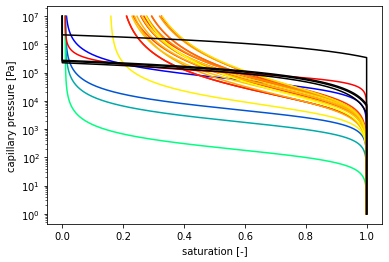

In [60]:
# make a giant plot of all the WRMs
import plot_wrm # $ATS_SRC_DIR/tools/utils
fig = plt.figure()
ax = fig.add_subplot(111)

cm_gl = workflow.colors.cm_mapper(100, 103, 'winter')
cm_ss = workflow.colors.cm_mapper(1000,1017, 'autumn')

for i in subsurface_props.index:
    if i < 999:
        cl = cm_gl(i)
    else:
        cl = cm_ss(i)
    alpha = subsurface_props.loc[i]['van Genuchten alpha [Pa^-1]']
    n = subsurface_props.loc[i]['van Genuchten n [-]']
    sr = subsurface_props.loc[i]['residual saturation [-]']
    vg = plot_wrm.VanGenuchten(alpha, n, sr)
    plot_wrm.plot(vg, ax, cl)
    

wp1 = plot_wrm.WiltingPointLimiter(7500, 275000)
wp2 = plot_wrm.WiltingPointLimiter(6600, 255000)
wp3 = plot_wrm.WiltingPointLimiter(3500, 224000)
wp4 = plot_wrm.WiltingPointLimiter(343245, 2196768)
for wp in [wp1, wp2, wp3, wp4]:
    plot_wrm.plot(wp, ax, 'k')

    
plt.show()